# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import torch
import ast
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [28]:
import sys
sys.path.append("../")
from Utils.CustomFunctions import train_MLmodels, compare_heatmaps, compare_performance
from Utils.neural_net import TextDataset, TrainLoopText
from Utils.models import LSTMmodel
from Utils.nlp import get_word_to_index

# Data

## Importing Data

In [4]:
image_embeddings = np.load("../Data/Images/Image Embeddings/EfficientNet.npy")
data = pd.read_csv("../Data/multimodal.csv")

In [5]:
data['Caption'] = data['Caption'].apply(ast.literal_eval)

In [6]:
texts = np.array(data['Caption'])
labels = np.array(data['LABEL'])

## Train test split

In [7]:
train_image, test_image, train_text, test_text, train_label, test_label = train_test_split(image_embeddings, texts, labels, test_size=0.2, shuffle=True, stratify=labels)
train_image, val_image, train_text, val_text, train_label, val_label = train_test_split(train_image, train_text, train_label, test_size=0.125, shuffle=True, stratify=train_label)

## Text dataset preparation

In [8]:
word_to_index = get_word_to_index("../.vector_cache/glove.twitter.27B.25d.txt")

In [9]:
train_set = TextDataset(train_text, train_label, word_to_index)
test_set = TextDataset(test_text, test_label, word_to_index)
val_set = TextDataset(val_text, val_label, word_to_index)

train_loader = DataLoader(train_set, 32)
test_loader = DataLoader(test_set, 32)
val_loader = DataLoader(val_set, 32)

# Modelling

## Images

In [12]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'MultinomialNB': MultinomialNB(),
    'GaussianNB': GaussianNB(),
    'SVC':SVC(),
    'AdaBoostClassifier':AdaBoostClassifier(),
    'XGBClassifier':XGBClassifier(),
    'LGBMClassifier':LGBMClassifier(),
    'CatBoostClassifier':CatBoostClassifier(task_type='GPU')
}

In [13]:
trained_models = train_MLmodels(models, train_image, train_label)

Training LogisticRegression
LogisticRegression Model Trained
Time taken = 0.751 seconds
------------------
Training DecisionTreeClassifier
DecisionTreeClassifier Model Trained
Time taken = 15.319 seconds
------------------
Training MultinomialNB
Model Skipped
------------------
Training GaussianNB
GaussianNB Model Trained
Time taken = 0.028 seconds
------------------
Training SVC
SVC Model Trained
Time taken = 12.349 seconds
------------------
Training AdaBoostClassifier
AdaBoostClassifier Model Trained
Time taken = 86.609 seconds
------------------
Training XGBClassifier
XGBClassifier Model Trained
Time taken = 84.603 seconds
------------------
Training LGBMClassifier
LGBMClassifier Model Trained
Time taken = 20.148 seconds
------------------
Training CatBoostClassifier
Learning rate set to 0.083352
0:	learn: 1.0922170	total: 317ms	remaining: 5m 16s
1:	learn: 1.0869596	total: 375ms	remaining: 3m 7s
2:	learn: 1.0820210	total: 430ms	remaining: 2m 22s
3:	learn: 1.0770922	total: 481ms	rem

In [14]:
compare_performance(trained_models, test_image, test_label)

,Name,Accuracy,Precision_0,Precision_1,Precision_2,Recall_0,Recall_1,Recall_2,f1-score_0,f1-score_1,f1-score_2
0,LogisticRegression,0.416,0.368,0.433,0.434,0.337,0.469,0.429,0.352,0.450,0.431
1,DecisionTreeClassifier,0.391,0.368,0.423,0.379,0.385,0.410,0.377,0.376,0.416,0.378
2,GaussianNB,0.382,0.365,0.377,0.398,0.302,0.390,0.444,0.331,0.383,0.420
3,SVC,0.429,0.424,0.420,0.444,0.268,0.525,0.468,0.328,0.467,0.456
4,AdaBoostClassifier,0.363,0.341,0.361,0.384,0.299,0.395,0.386,0.319,0.377,0.385
5,XGBClassifier,0.446,0.414,0.446,0.463,0.289,0.528,0.495,0.340,0.484,0.479
6,LGBMClassifier,0.432,0.456,0.423,0.430,0.306,0.520,0.450,0.366,0.466,0.440
7,CatBoostClassifier,0.460,0.446,0.459,0.468,0.313,0.528,0.517,0.368,0.491,0.491


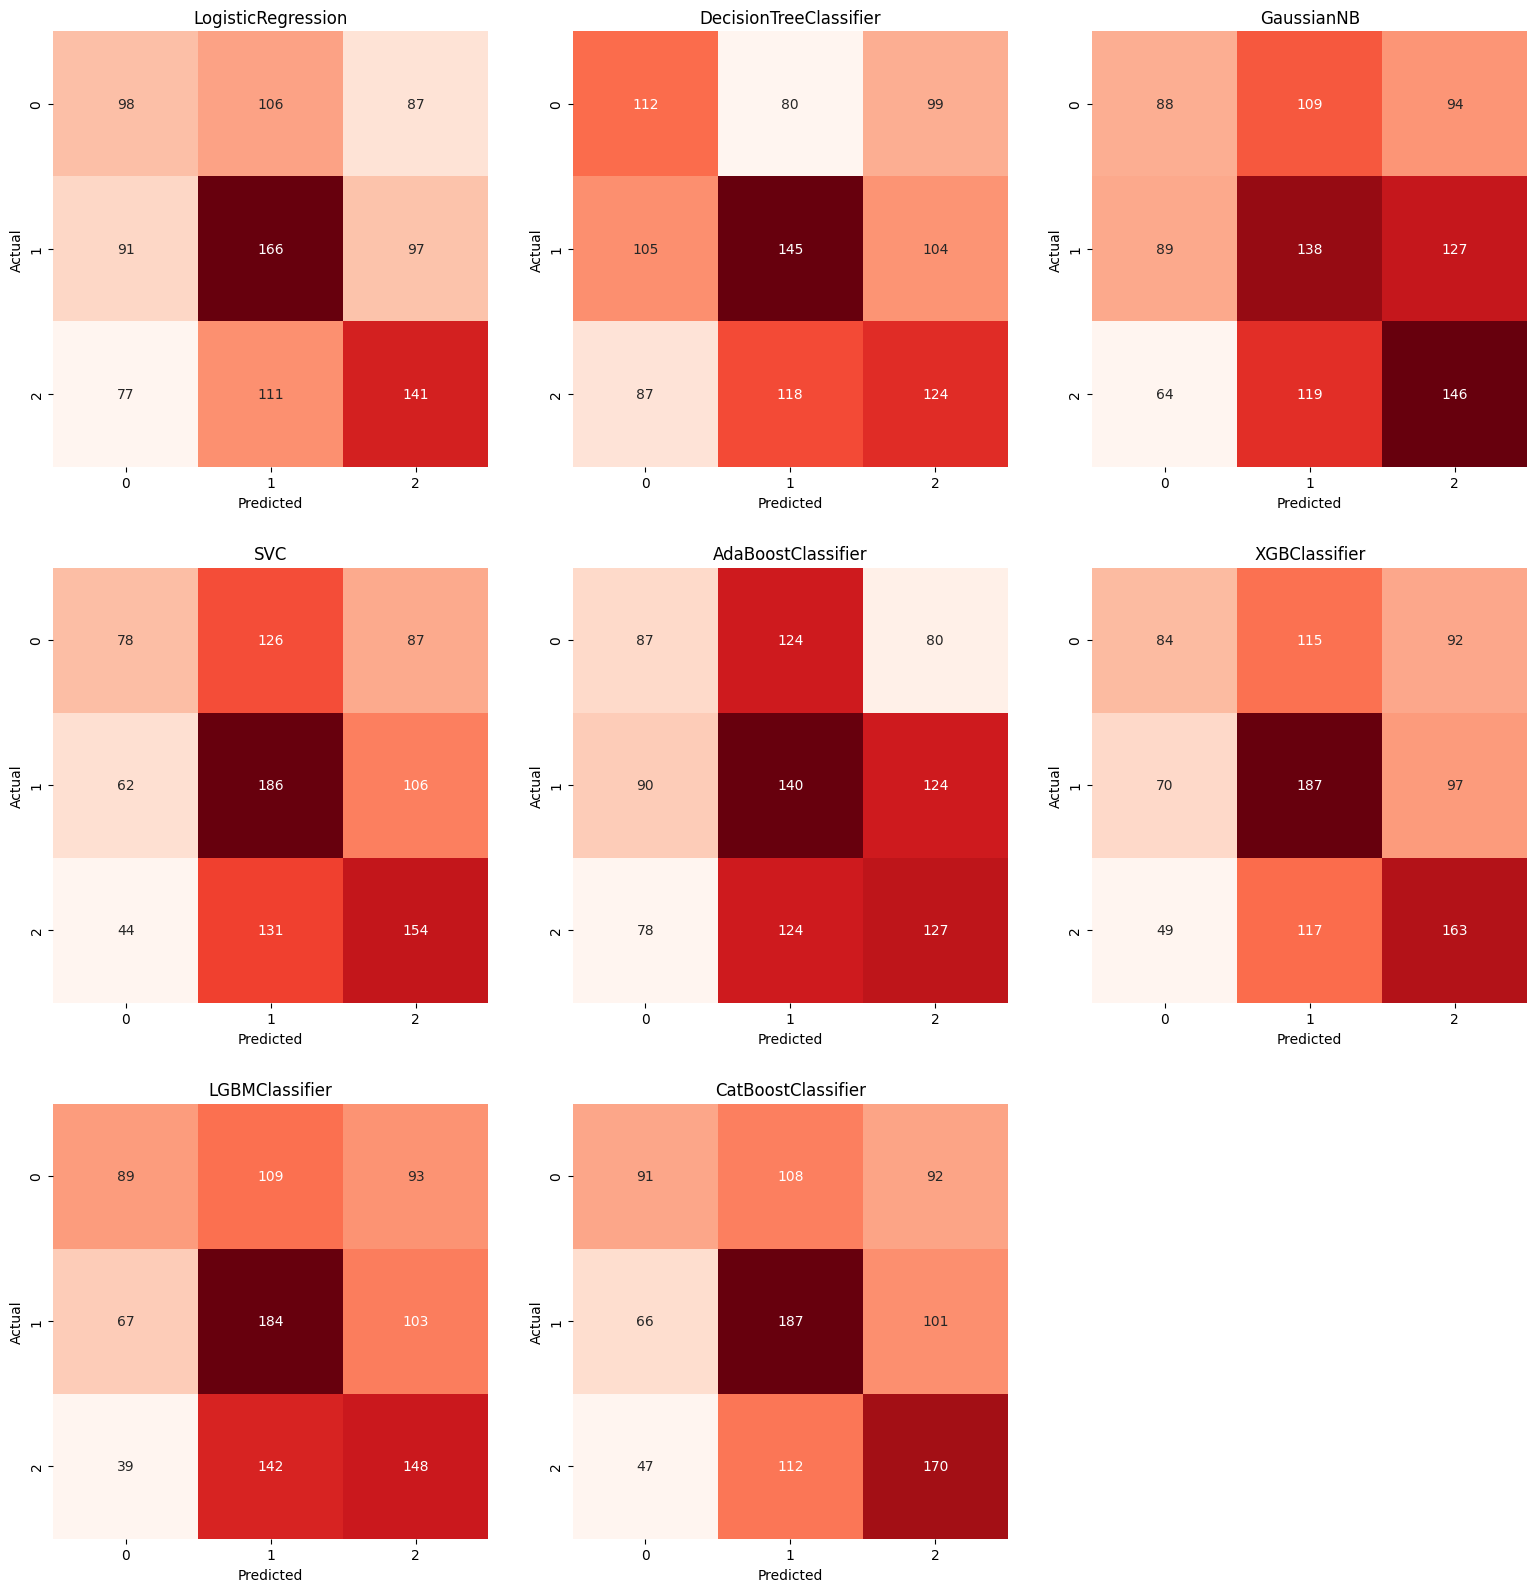

In [15]:
compare_heatmaps(trained_models, test_image, test_label)

In [21]:
cat_model = CatBoostClassifier(use_best_model=True, task_type='GPU', early_stopping_rounds=200)
cat_model.fit(train_image, train_label, eval_set=(val_image, val_label))

Learning rate set to 0.119018
0:	learn: 1.0896205	test: 1.0965532	best: 1.0965532 (0)	total: 66.6ms	remaining: 1m 6s
1:	learn: 1.0822955	test: 1.0976287	best: 1.0965532 (0)	total: 125ms	remaining: 1m 2s
2:	learn: 1.0754483	test: 1.0972138	best: 1.0965532 (0)	total: 174ms	remaining: 57.9s
3:	learn: 1.0686635	test: 1.0964240	best: 1.0964240 (3)	total: 227ms	remaining: 56.6s
4:	learn: 1.0623614	test: 1.0940545	best: 1.0940545 (4)	total: 277ms	remaining: 55.1s
5:	learn: 1.0552930	test: 1.0933423	best: 1.0933423 (5)	total: 323ms	remaining: 53.5s
6:	learn: 1.0481469	test: 1.0938183	best: 1.0933423 (5)	total: 370ms	remaining: 52.5s
7:	learn: 1.0407920	test: 1.0941567	best: 1.0933423 (5)	total: 416ms	remaining: 51.6s
8:	learn: 1.0336787	test: 1.0955996	best: 1.0933423 (5)	total: 463ms	remaining: 51s
9:	learn: 1.0278716	test: 1.0965346	best: 1.0933423 (5)	total: 514ms	remaining: 50.9s
10:	learn: 1.0203736	test: 1.0969184	best: 1.0933423 (5)	total: 563ms	remaining: 50.6s
11:	learn: 1.0149800	tes

                 Model Performance
              precision    recall  f1-score   support

           0       0.42      0.28      0.33       291
           1       0.43      0.53      0.47       354
           2       0.43      0.44      0.44       329

    accuracy                           0.43       974
   macro avg       0.43      0.42      0.42       974
weighted avg       0.43      0.43      0.42       974

Accuracy = 42.71%


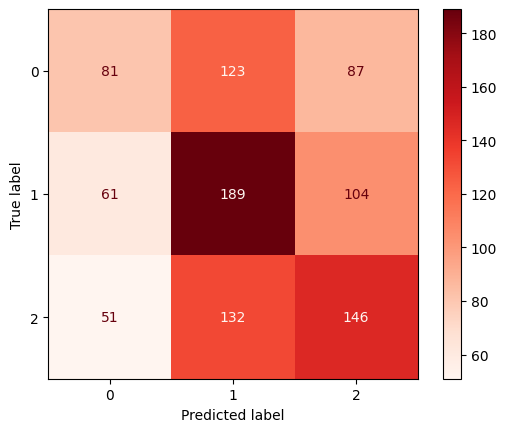

In [22]:
from Utils.CustomFunctions import performance
performance(cat_model, test_image, test_label)

                 Model Performance
              precision    recall  f1-score   support

           0       0.45      0.31      0.37       291
           1       0.46      0.53      0.49       354
           2       0.47      0.52      0.49       329

    accuracy                           0.46       974
   macro avg       0.46      0.45      0.45       974
weighted avg       0.46      0.46      0.45       974

Accuracy = 46.0%


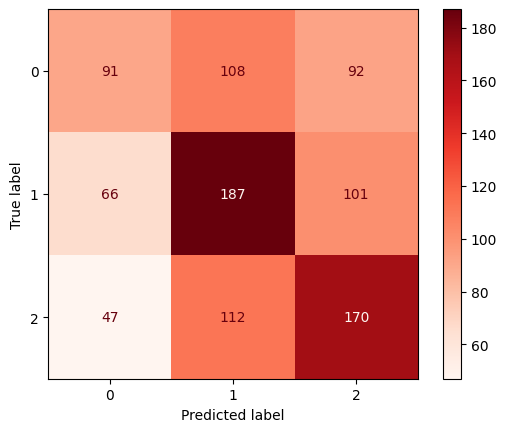

In [23]:
performance(trained_models['CatBoostClassifier'], test_image, test_label)

In [50]:
image_preds = trained_models['CatBoostClassifier'].predict_proba(train_image)

                 Model Performance
              precision    recall  f1-score   support

           0       0.46      0.31      0.37       291
           1       0.42      0.52      0.47       354
           2       0.43      0.45      0.44       329

    accuracy                           0.43       974
   macro avg       0.44      0.43      0.42       974
weighted avg       0.44      0.43      0.43       974

Accuracy = 43.22%


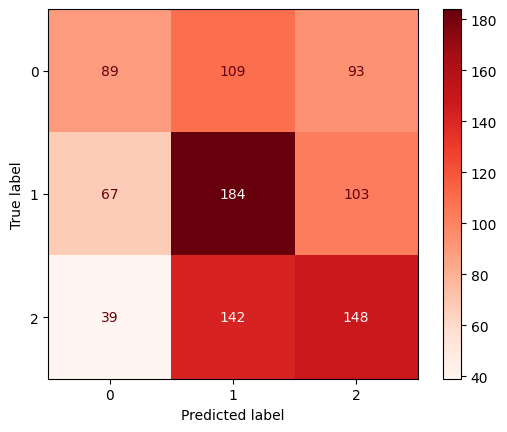

In [27]:
performance(trained_models['LGBMClassifier'], test_image, test_label)

## Text

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.1041045188903809
Loss for batch 1 = 1.1180702447891235
Loss for batch 2 = 1.1045143604278564
Loss for batch 3 = 1.079235553741455
Loss for batch 4 = 1.0712014436721802
Loss for batch 5 = 1.1069543361663818
Loss for batch 6 = 1.1343954801559448
Loss for batch 7 = 1.105512022972107
Loss for batch 8 = 1.0885028839111328
Loss for batch 9 = 1.101430058479309
Loss for batch 10 = 1.0974667072296143
Loss for batch 11 = 1.0779021978378296
Loss for batch 12 = 1.1020126342773438
Loss for batch 13 = 1.0787642002105713
Loss for batch 14 = 1.096781611442566
Loss for batch 15 = 1.1021971702575684
Loss for batch 16 = 1.0817255973815918
Loss for batch 17 = 1.1184364557266235
Loss for batch 18 = 1.0828274488449097
Loss for batch 19 = 1.1123628616333008
Loss for batch 20 = 1.1087987422943115
Loss for batch 21 = 1.0698938369750977
Loss for batch 22 = 1.0820025205612183
Loss for batch 23 = 1.0786352157592773
Loss for batch 24 = 1.0885417461395264
Loss for batch 25 =

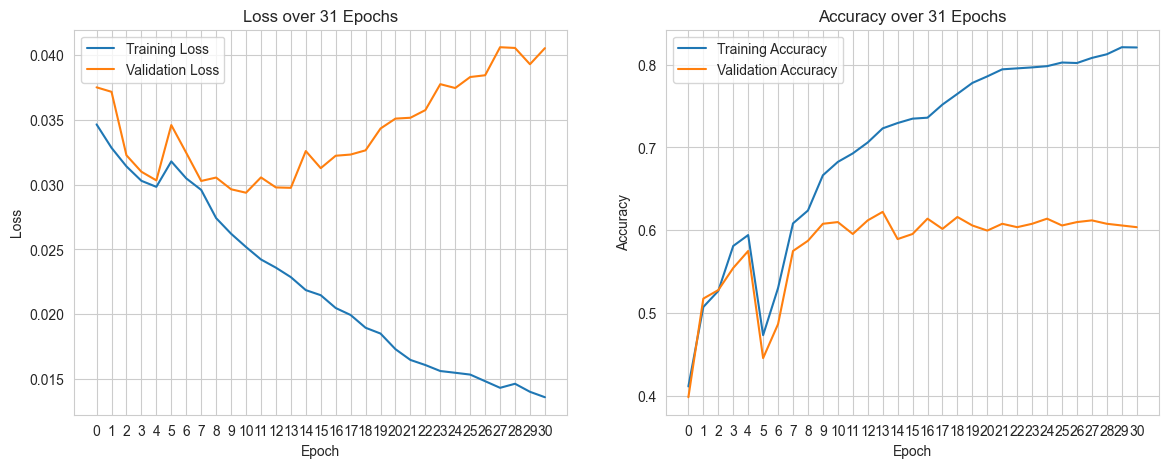

In [33]:
text_modelv1 = LSTMmodel(3, 25, 512, bidirectionality=True, freeze=False)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.NAdam(text_modelv1.parameters(), 0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.4, 8)
TrainLoopText(text_modelv1, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 20, device='cuda')

In [34]:
from sklearn.metrics import accuracy_score
true_labels = []
pred_labels = []
text_preds = []
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv1(texts)
        text_preds.extend(outputs.cpu().numpy())
        preds = torch.argmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

model_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {model_accuracy * 100:.2f}%')

Accuracy: 60.57%


In [44]:
true_labels = []
text_preds = []
with torch.inference_mode():
    for batch in train_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv1(texts)
        text_preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [46]:
np.unique(true_labels == train_label)

array([ True])

In [48]:
text_preds = np.array(text_preds)

In [51]:
text_preds.shape, image_preds.shape

((3408, 3), (3408, 3))

In [53]:
train_preds = np.hstack([text_preds, image_preds])
train_preds.shape

(3408, 6)

In [54]:
torch.cuda.empty_cache()
true_labels = []
text_preds = []
with torch.inference_mode():
    for batch in val_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv1(texts)
        text_preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

text_preds = np.array(text_preds)
image_preds = trained_models['CatBoostClassifier'].predict_proba(val_image)

val_preds = np.hstack([text_preds, image_preds])
val_preds.shape

(487, 6)

In [55]:
torch.cuda.empty_cache()
true_labels = []
text_preds = []
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv1(texts)
        text_preds.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

text_preds = np.array(text_preds)
image_preds = trained_models['CatBoostClassifier'].predict_proba(test_image)

test_preds = np.hstack([text_preds, image_preds])
test_preds.shape

(974, 6)

In [56]:
cat_mm = CatBoostClassifier(task_type='GPU', use_best_model=True)
cat_mm.fit(train_preds,train_label, eval_set=(val_preds, val_label))

Learning rate set to 0.119018
0:	learn: 0.8826981	test: 1.0765357	best: 1.0765357 (0)	total: 24.1ms	remaining: 24.1s
1:	learn: 0.7277617	test: 1.0614570	best: 1.0614570 (1)	total: 46.9ms	remaining: 23.4s
2:	learn: 0.6107560	test: 1.0503242	best: 1.0503242 (2)	total: 60.6ms	remaining: 20.2s
3:	learn: 0.5196440	test: 1.0447195	best: 1.0447195 (3)	total: 72.3ms	remaining: 18s
4:	learn: 0.4454714	test: 1.0205472	best: 1.0205472 (4)	total: 83.5ms	remaining: 16.6s
5:	learn: 0.3846570	test: 1.0172913	best: 1.0172913 (5)	total: 94.2ms	remaining: 15.6s
6:	learn: 0.3336974	test: 1.0103901	best: 1.0103901 (6)	total: 106ms	remaining: 15.1s
7:	learn: 0.2907779	test: 1.0048716	best: 1.0048716 (7)	total: 120ms	remaining: 14.9s
8:	learn: 0.2544156	test: 0.9973211	best: 0.9973211 (8)	total: 132ms	remaining: 14.6s
9:	learn: 0.2232201	test: 0.9943333	best: 0.9943333 (9)	total: 144ms	remaining: 14.3s
10:	learn: 0.1963080	test: 0.9952445	best: 0.9943333 (9)	total: 155ms	remaining: 14s
11:	learn: 0.1734385	

                 Model Performance
              precision    recall  f1-score   support

           0       0.56      0.10      0.17       291
           1       0.52      0.65      0.58       354
           2       0.47      0.69      0.56       329

    accuracy                           0.50       974
   macro avg       0.52      0.48      0.44       974
weighted avg       0.52      0.50      0.45       974

Accuracy = 49.9%


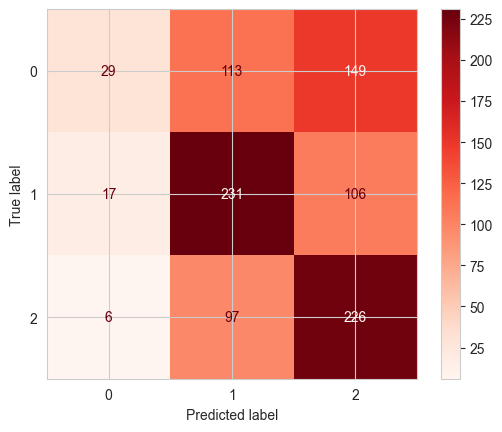

In [57]:
performance(cat_mm, test_preds, test_label)